# Bayesian Inference Assisted Energy Model Calibration

# Import Libraries and Modules

In [1]:
import os
#os.chdir(os.path.join(os.getcwd(), 'src'))

import time
import pandas as pd
import numpy as np
import arviz as az
import multiprocessing as mp
from functools import partial
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.metrics import r2_score
try:
    import plots 
except:
    import src.plots as plots
try:
    import inputs 
except:
    import src.inputs as inputs
try:
    import paths 
except:
    import src.paths as paths

from run_DIBS import run_model
from SensitivityAnalysis import find_converged_sa_sample_size
from run_SA import run_SA
from GaussianProcesses import perform_gp_convergence
from run_GP_samples import sample_gp
from run_GP_train import train_gp
from BayesianCalibration import run_calibration
from multisimulationFunction import run_simulation

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def calculate_cvrmse_r2(measured, simulated):
    '''Calculate CV(RMSE) and R2 for a single simulation run.'''
    rmse = np.sqrt(np.mean((simulated - measured)**2))
    cvrmse = (rmse / np.mean(measured)) * 100
    r2 = r2_score(measured, simulated)
    return cvrmse, r2


# User Inputs

In [4]:
start_process = time.time()

''' REQUIRED INPUTS '''
scr_gebaeude_id = 30034001          # Building ID
calib_type = 'TRY'                  # AMY: Actual Meteorological Year, TRY: Test Reference Year (works only for Germany)
output_resolution = None            # Time resolution for the metered data and calibration: Y = Yearly, M = Monthly, W = Weekly, etc, None = for TRY version
climate_file = None                 # Name of the climate file 'AMY_2010_2022.epw'

''' OPTIONAL INPUTS '''
num_bc_param = 5                    # Number of model parameters to be calibrated
SA_Convergence_Required = 'Y'       # Preference to run automatized convergence check for Sensitivity Analysis
SA_sampling_lowerbound = 4          # Minimum number of samples (N) for Sensitivity Analysis ((N*(2D+2))). D=Dimensions, number of parameters
SA_sampling_upperbound = 9          # Maximum number of samples for Sensitivity Analysis (This limit prevents excessively long runtimes if the sensitivity index parameter order does not converge)
GP_Convergence_Required = 'Y'       # Preference to run automatized convergence check for meta-model creation
min_gp_samples = 66                # Minimum number of samples for meta-model training
max_gp_samples = 100             # Maximum number of samples for meta-model training
step_gp = 2                       # Increase in sample size for each new meta-model training
rmse_threshold = 0.0007             # RMSE criteria for the meta-model
gp_test_size = 25/100               # Proportion of samples for GP to be used for the evaluation of the meta-model
training_ratio = 75                 # Percentage of observed data to be used for the calibration
draws, tune, chains = 100, 200, 4   # Bayesian Calibration parameters



# Import Data 

In [5]:
''' IMPORT DATA '''
metered=pd.read_excel(os.path.join(paths.DATA_DIR, 'HeatEnergyDemand_{}_{}.xlsx'.format(scr_gebaeude_id, output_resolution)), index_col=0)
nr_train_data = round(metered[1:].shape[0]*training_ratio/100)
start_time_cal, end_time_cal = metered.index[0].strftime('%Y-%m-%d %H:%M:%S'), metered.index[nr_train_data].strftime('%Y-%m-%d %H:%M:%S')
start_time, end_time = metered.index[0].strftime('%Y-%m-%d %H:%M:%S'), metered.index[-1].strftime('%Y-%m-%d %H:%M:%S')
print(f'Calibration starts at: {start_time_cal}, and ends at: {end_time_cal}')

''' (0) Process Controll File'''
df = pd.DataFrame()
df['Name'] = ['Step done', 'Duration time in seconds', 'Other info', 'Other info', 'Other info', 'Other info', 'Other info', 'Other info']
ctrl_file = os.path.join(paths.CTRL_DIR, f'process_intermittent_check_{scr_gebaeude_id}_{calib_type}_{output_resolution}_{str(training_ratio)}.xlsx')
df.to_excel(ctrl_file)


Calibration starts at: 2010-01-01 00:00:00, and ends at: 2015-12-31 23:00:00


In [6]:
''' (1) DIBS Simulation '''
start_calc = time.time()

HeatingEnergy_sum = run_model(scr_gebaeude_id, 
                            climate_file, 
                            start_time, 
                            end_time, 
                            output_resolution, 
                            training_ratio)   

end_calc = time.time()
if output_resolution == None:
    HeatingEnergy_sum = HeatingEnergy_sum.tolist()
else: 
    HeatingEnergy_sum = HeatingEnergy_sum['HeatingEnergy'].values.tolist()
df['DIBS'] = ['DIBS simulation is working', end_calc-start_calc, 'Uncalibrated sim result, kWh: ', f'{HeatingEnergy_sum}', '-', '-', '-', '-']
df.to_excel(ctrl_file, index=False)

# Plot
fig = plots.plot_model(scr_gebaeude_id, output_resolution, training_ratio)
fig.show()

14
Generated 704 parameter combinations for 16 samples. Cores allocated for simulation are 14
Files_written 16
S1 estimates written 16
Sampling done  16
Sample Size: 16
Top 5 ST Parameters: [13 19 14 21 20]
Generated 1408 parameter combinations for 32 samples. Cores allocated for simulation are 14
Files_written 32
S1 estimates written 32
Sampling done  32
Sample Size: 32
Top 5 ST Parameters: [13 19 14 20 21]
Generated 2816 parameter combinations for 64 samples. Cores allocated for simulation are 14
Files_written 64
S1 estimates written 64
Sampling done  64
Sample Size: 64
Top 5 ST Parameters: [13 19 14 20 21]
Time: 2399.7848410606384
The sample size for which the ranking of the top five parameters doesn't change compared to the previous sample size is 64.


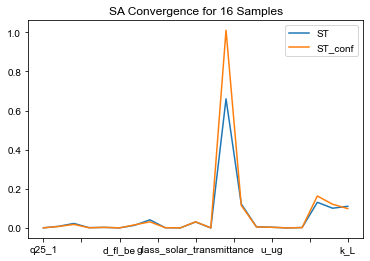

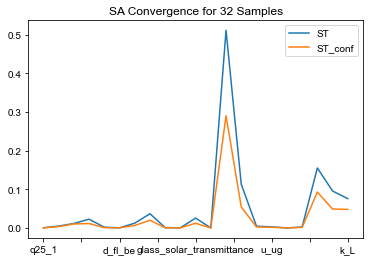

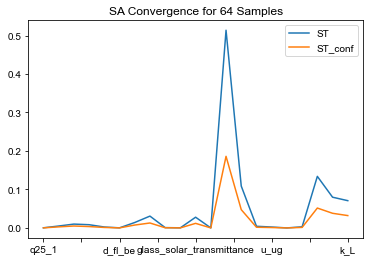

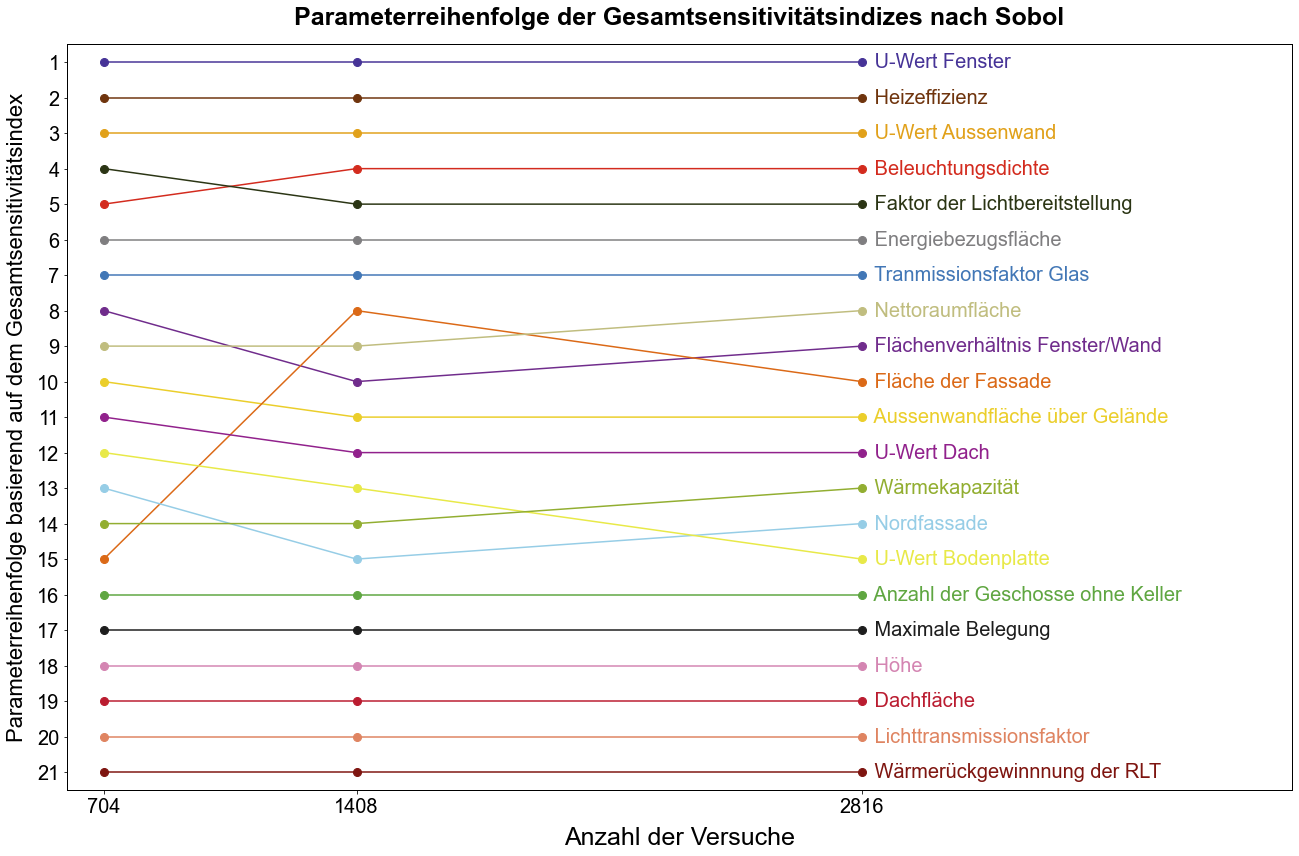

In [7]:
''' (2) Sensitivity Analysis'''
if SA_Convergence_Required == 'Y':             
    num_samples_sa, sa_converged, calc_time_SA = find_converged_sa_sample_size(scr_gebaeude_id, 
                                                                               calib_type, 
                                                                               climate_file, 
                                                                               start_time_cal, 
                                                                               end_time_cal, 
                                                                               output_resolution, 
                                                                               training_ratio,  
                                                                               SA_sampling_lowerbound, 
                                                                               SA_sampling_upperbound)

    ''' No automatized convergence '''
else:
    sa_converged = 0
    num_samples_sa = 32     # Default number of samples for determination of most sensible parameters.
    total_SI, calc_time_SA = run_SA(scr_gebaeude_id, num_samples_sa, climate_file, start_time_cal, end_time_cal, output_resolution, training_ratio) 
        
df['SA'] = ['SA is done', f'Convergence time: {calc_time_SA}', f'Num samples: {num_samples_sa}', f'SA Converged: {sa_converged}', f'SA_Convergence_Required: {SA_Convergence_Required}', '-', '-', '-']
df.to_excel(ctrl_file, index=False)

In [8]:
if GP_Convergence_Required == 'Y':
    best_result, best_kernel_path, best_samples_df_path, conv_time = perform_gp_convergence(scr_gebaeude_id, climate_file, output_resolution, calib_type, 
                                                                                            start_time_cal, end_time_cal, min_gp_samples, max_gp_samples, 
                                                                                            num_bc_param, num_samples_sa, step_gp, rmse_threshold, 
                                                                                            gp_test_size, training_ratio)
    best_rmse_norm = best_result['RMSE_NORM']
    kernel_index = best_result['Kernel_Index']
    kernel = best_result['Kernel']
    num_samples_gp = best_result['Num_Samples_GP']

    df['GP convergence'] = ['GP is done', conv_time, f'num_samples_gp: {num_samples_gp}', f'num_bc_param: {num_bc_param}', f'num_samples_sa: {num_samples_sa}', f'climate_file: {climate_file}', f'output_resolution: {output_resolution}', '-']
    df.to_excel(ctrl_file, index=False)

    ''' No automatized convergence '''
else:
    num_samples_gp = 80     # Default number of samples for the training & testing of the meta-model.
    kernel, kernel_index = 1 * RationalQuadratic(), 1   # Default Kernel

    # Sampling for the Gaussian Processes
    start = time.time()
    samples_df, calc_time = sample_gp(scr_gebaeude_id, num_bc_param, num_samples_sa, num_samples_gp, climate_file, start_time_cal, end_time_cal, output_resolution, training_ratio)
    finish = time.time()
    df['GP sample'] = ['GP samples is done', finish-start, f'num_samples_gp: {num_samples_gp}', f'num_bc_param: {num_bc_param}', f'num_samples_sa: {num_samples_sa}', f'climate_file: {climate_file}', f'start_time, end_time: {start_time}, {end_time}', f'output_resolution: {output_resolution}']
    df.to_excel(ctrl_file, index=False)
        
    # Training the meta-model
    start = time.time()
    kernel_trained, mse, mae, rmse, r2, sigma, y_test_mean, mape = train_gp(scr_gebaeude_id, num_bc_param, kernel, kernel_index, num_samples_gp, gp_test_size, output_resolution, training_ratio) 
    finish = time.time()
    df['GP train'] = ['GP train is done', finish-start, f'bc_param: {num_bc_param}, training_ratio: {training_ratio}, samples: {num_samples_gp}', f'Kernel: {kernel_trained}', f'Kernel index: {kernel_index}, GP test size: {gp_test_size}', f'MAPE: {mape} / MSE: {mse} / RMSE: {rmse} / MAE: {mae}', f'r2-score: {r2}', f'std of prediction: {sigma}']
    df.to_excel(ctrl_file, index=False)

Total CPU cores: 16
Cores to be used for processing: 14

RMSE threshold of 0.0007 and R² > 0.99 reached!


OSError: Cannot save file into a non-existent directory: 'c:\Users\Kata\Desktop\caliblab\control\GP'

In [ ]:

''' (5) Bayesian Calibration '''
from BayesianCalibration import plot_calibration_results
threshold = 1.01    # Gelman-Rubin convergence diagnostic criteria
kernel_index =1
num_samples_gp = 72
start = time.time()
trace, converged, draws, tune, chains = run_calibration(scr_gebaeude_id, num_bc_param, 
                                                        draws, tune, chains, 
                                                        num_samples_gp, kernel_index, 
                                                        output_resolution,training_ratio, 
                                                        start_time_cal, end_time_cal, 
                                                        threshold)

if converged:
    print(f'Bayesian calibration converged at {tune} tunes and {draws} draws')
    summary = plot_calibration_results(scr_gebaeude_id,num_bc_param,
                output_resolution,training_ratio,draws=draws,tune=tune,
                chains=chains)

else:
    print(f'Did not converge for training_ratio = {training_ratio}')
finish = time.time()

df[f'BC training_ratio: {training_ratio}, num_bc_param: {num_bc_param}'] = ['BC is done', finish-start, f'num bc param: {num_bc_param}', f'{tune} tunes, {draws} draws, {chains} chains', f'output resolution: {output_resolution}','-','-','-']
df.to_excel(ctrl_file, index=False)



finish_process = time.time()
print(f'The framework required {(finish_process-start_process)/3600} hours to complete.')


# Simulate with Calibrated Model

In [ ]:

from run_calibModel import run_parallel_simulations, create_violin_plot
def main():
    if converged:
        df_params, results_df = run_parallel_simulations(
        scr_gebaeude_id,
        num_bc_param,
        draws,
        tune,
        chains,
        output_resolution,
        training_ratio,
        start_time,
        end_time,
        climate_file,
        ctrl_file
    )
        
    violin_fig = create_violin_plot(scr_gebaeude_id, num_bc_param, output_resolution, 
                                training_ratio, draws, tune, start_time, end_time, calib_type)
    violin_fig.show()
    
if __name__ == '__main__':
    mp.freeze_support()
    main()
    


In [ ]:
'''
from run_calibModel import run_parallel_simulations, create_violin_plot
draws = 128
tune = 100
violin_fig = create_violin_plot(scr_gebaeude_id, num_bc_param, output_resolution, 
                                training_ratio, draws, tune, start_time, end_time, calib_type)
violin_fig.show()

'''